Desired Outcome(s):
1. "Items" table to support the following schema:
``` typescript
    export interface Item {
        id: number; // assign a unique id
        course_id: number; // from source directory
        author: string; // from source directory
        source_url: string; // from source directory
        file_name: string; // from file properties
        number_pages: number; // from file properties
        name: string; // generated from file
        summary: string; // generated from file
        sections: jsonb = {
            page_start: number,
            page_end: number,
            title: string,
            summary: string,
        };// generated from file
        snippet: string; // made from previous fields
        embedding: vector; // made with snippet
    }
```
2. "Documents" table to support the following schema:
``` typescript
    export interface Document {
        id: number;
        content: string;
        metadata: jsonb = {
            item_id: number,
            course_id: number,
            previous_id: number,
            next_id: number,
        };
        embedding: vector;
    }
```
3. "Courses" table to support the following schema:
``` typescript
    export interface Course {
        id: number; // assign a unique id
        name: string; // from source directory
        summary: string; // generated from file
        snippet: string; // made from previous fields
        embedding: vector; // made with snippet
    }
```
3. Create Documents from FileStore
4. Generate Items from Documents
5. Generate Courses from Items
5. Upsert Data into DB

```python
embedding_dimesions = 1536 # OpenAI Embedding Dimensions
```

### 1. Create Items Table
``` sql
CREATE TABLE items (
  id SERIAL PRIMARY KEY,
  course_id INTEGER,
  author VARCHAR(255),
  source_url VARCHAR(255),
  file_name VARCHAR(255),
  number_pages INTEGER,
  name VARCHAR(255),
  summary TEXT,
  sections JSONB,
  snippet TEXT,
  embedding VECTOR (1536)
);
```

### 2. Create Documents Table
``` sql
create table
  documents (
    id BIGSERIAL PRIMARY KEY,
    content TEXT, -- corresponds to Document.pageContent
    metadata JSONB, -- corresponds to Document.metadata
    embedding VECTOR (1536) -- 1536 works for OpenAI embeddings, change if needed
  );
```

### 3. Create Courses Table
``` sql
create table
  courses (
    id SERIAL PRIMARY KEY,
    name VARCHAR(255),
    summary TEXT,
    snippet TEXT,
    embedding VECTOR (1536) -- 1536 works for OpenAI embeddings, change if needed
  );
```

### 4. Create Documents from FileStore

In [2]:
from langchain_community.document_loaders import DirectoryLoader, UnstructuredFileLoader
from unstructured.cleaners.core import clean_extra_whitespace
from  langchain.schema import Document

paths = [
    "test-files/BA 476/",
    "test-files/ENTR 101/",
    "test-files/MKT 403/"
]

""" Returns a list of Document objects, each with a list of Element objects. Proccessed in order of the directory."""
docs = []
for path in paths:

    print("Loading from path: {}".format(path))

    loader = DirectoryLoader(
        path=path,
        show_progress=True,
        loader_cls=UnstructuredFileLoader,
        loader_kwargs={
            "mode": "elements",
            "post_processors": [clean_extra_whitespace]
        }
    )

    docs.extend(loader.load_and_split())

Loading from path: test-files/BA 476/


  0%|          | 0/18 [00:00<?, ?it/s]/Users/suibhneofoighil/yes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 18/18 [02:16<00:00,  7.60s/it]


Loading from path: test-files/ENTR 101/


100%|██████████| 12/12 [00:20<00:00,  1.71s/it]


Loading from path: test-files/MKT 403/


100%|██████████| 9/9 [01:21<00:00,  9.10s/it]


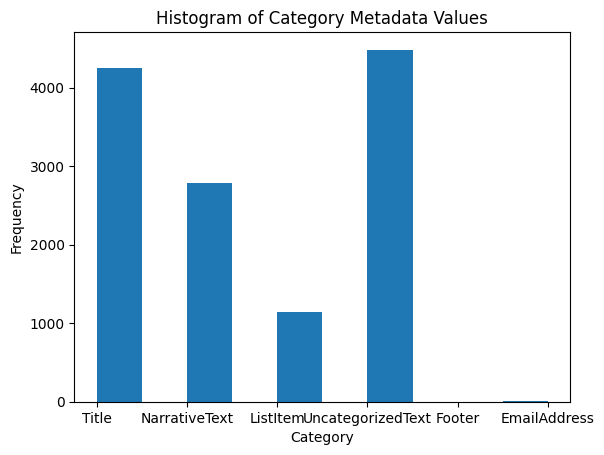

In [5]:
import matplotlib.pyplot as plt

# Extract category metadata values
category_values = [doc.metadata.get('category') for doc in docs if 'category' in doc.metadata]

# Create a histogram
plt.hist(category_values)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Histogram of Category Metadata Values')

# Display the histogram
plt.show()


In [6]:
def join_documents(docs):
    """Joins documents with the same page number and source."""

    def is_valid(doc):
        return isinstance(doc.metadata.get('source'), str) and isinstance(doc.metadata.get('page_number'), int) and isinstance(doc.page_content, str) and doc.page_content != ''

    def format_page_content(doc):
        """
        Removes leading and trailing whitespace and newlines.
        Adds "# " to the beginning of each "Title" document.
        Adds "* " to the beginning of each "ListItem" document.
        Returns formatted document
        """
        page_content = doc.page_content.strip()
        if doc.metadata.get('category') == 'Title':
            header = "# "
            if 'category_depth' in doc.metadata:
                if doc.metadata.get('category_depth') == 1:
                    header = "## "
                elif doc.metadata.get('category_depth') > 1:
                    header = "### "
            page_content = f"{header}{page_content}"
        elif doc.metadata.get('category') == 'ListItem':
            page_content = f"* {page_content}"
        doc.page_content = page_content
        return doc

    # Clean the metadata for the documents
    cleaned_docs = [doc for doc in docs if is_valid(doc)]

    # Format the page content for the documents
    formatted_docs = [format_page_content(doc) for doc in cleaned_docs]

    # Sort the documents by page number and source
    sorted_docs = sorted(formatted_docs, key=lambda doc: (doc.metadata.get('source'), doc.metadata.get('page_number')))

    joined_docs = []
    current_doc = None

    for doc in sorted_docs:
        if current_doc is None:
            current_doc = doc
        elif current_doc.metadata.get('page_number') == doc.metadata.get('page_number') and current_doc.metadata.get('source') == doc.metadata.get('source'):
            current_doc.page_content += f"\n{doc.page_content}"
        else:
            joined_docs.append(current_doc)
            current_doc = doc

    if current_doc is not None:
        joined_docs.append(current_doc)

    return joined_docs

# Apply the join_documents() function
print("Number of Documents Before: ", len(docs))
joined_docs = join_documents(docs)
print("Number of Documents After: ", len(joined_docs))

Number of Documents Before:  12678
Number of Documents After:  1020


In [7]:
def filter_short_documents(docs, threshold):
    """Filters out documents with page_content shorter than the threshold."""
    return [doc for doc in docs if len(doc.page_content) >= threshold]

# Define the threshold value
threshold = 100

# Apply the filter_short_documents() function
print("Number of Documents Before: ", len(joined_docs))
filtered_docs = filter_short_documents(joined_docs, threshold)
print("Number of Documents After: ", len(filtered_docs))

Number of Documents Before:  1020
Number of Documents After:  834


In [8]:
""" Combine documents that are too long """
# Define the threshold value
threshold = 3000

from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=threshold,
    chunk_overlap=0, # No overlap because we'll link chunks with document ids
    length_function=len,
    is_separator_regex=False,
)

# Split the too long documents
split_docs = text_splitter.transform_documents(
    filtered_docs
)

# Print the final number of documents
print("Number of Documents Before: ", len(filtered_docs))
print("Number of Documents After: ", len(split_docs))

Number of Documents Before:  834
Number of Documents After:  991


In [10]:
""" subsection of transformed documents should remain in the same order as the original documents, if they have the same source """
subsection = split_docs[888:900]
for doc in subsection:
    source = doc.metadata.get('source')
    page_number = doc.metadata.get('page_number')
    content = doc.page_content
    print("Source: ", source)
    print("Page Number: ", page_number)
    print("Content: ", content)
    print()

Source:  test-files/MKT 403/SearchFundPrimer-Aug2010.pdf
Page Number:  83
Content:  # Debt – amount and general terms
Equity – final amount needed
# Major due diligence findings
# Significant terms in the purchase agreement for the company.
Within 30 days after closing, the searcher will begin his regular reporting to his investors. In the first report, he will provide further updates on any last minute changes to the transaction from his most recent pre-closing communication, highlights of what he has accomplished on the transition, his impressions of the business, and his roadmap for the upcoming months.
# EDUCATION AND EVALUATION
Successful search funders recommend the first 100 days be spent with the goal of learning the business intimately and evaluating all aspects of the business. Many view it is a second due diligence process, but this time when the CEO has full access to employees, customers, suppliers, systems and information. During the transition period, the search fund ent

In [11]:
" Link documents to previous and next documents if they are from the same source "

# initialize the previous_document_id and next_document_id metadata values
for doc in split_docs:
    doc.metadata['previous_document_id'] = None
    doc.metadata['next_document_id'] = None

# link the documents
for i, doc in enumerate(split_docs):
    if i > 0 and doc.metadata.get('source') == split_docs[i - 1].metadata.get('source'):
        doc.metadata['previous_document_id'] = split_docs[i - 1].metadata.get('id')
        split_docs[i - 1].metadata['next_document_id'] = doc.metadata.get('id')

### 4. Generate Database Content
Reminder of the desired outcome:
``` typescript
    export interface Item {
        id: number; // assign a unique id
        course_id: number; // from source directory
        author: string; // from source directory
        source_url: string; // from source directory
        file_name: string; // from file properties
        number_pages: number; // from file properties
        name: string; // generated from file
        summary: string; // generated from file
        sections: jsonb = {
            page_start: number,
            page_end: number,
            title: string,
            summary: string,
        };// generated from file
        snippet: string; // made from previous fields
        embedding: vector; // made with snippet
    }
    export interface Document {
        id: number;
        content: string;
        metadata: jsonb = {
            item_id: number,
            course_id: number,
            previous_id: number,
            next_id: number,
        };
        embedding: vector;
    }
    export interface Course {
        id: number; // assign a unique id
        name: string; // from source directory
        summary: string; // generated from file
        snippet: string; // made from previous fields
        embedding: vector; // made with snippet
    }
```

In [13]:
""" Hardcode the Course data """
courses_to_upsert = [
    {
        "id": 0,
        "name": "Business History",
        "description": "This course is an introduction to the history of business in the United States. It will examine the evolution of business in the United States from the colonial era to the present. The course will emphasize the development of the American economy and the role of business in that development. It will also examine the relationship between business and the broader society. The course will be taught through a combination of lectures, discussions, and case studies. Students will be expected to read and discuss a variety of primary and secondary sources. Students will also be expected to write a research paper on a topic of their choice related to the course content.",
        "code": "BA 476",
    },
    {
        "id": 1,
        "name": "Market Analysis",
        "description": "This course provides an introduction to the principles and practices of marketing. It covers topics such as market research, consumer behavior, product development, pricing strategies, promotion, and distribution. Students will learn how to analyze market trends, identify target markets, develop marketing strategies, and measure the effectiveness of marketing campaigns.",
        "code": "MKT 403",
    },
    {
        "id": 2,
        "name": "Entrepreneurship",
        "description": "This course provides an introduction to the principles and practices of entrepreneurship. It covers topics such as market research, business planning, financing, marketing, and management. Students will learn how to identify opportunities, develop business plans, raise capital, and manage growth.",
        "code": "ENTR 101",
    }
]

In [14]:
# Get the unique metadata fields
unique_metadata_fields = set()
for doc in split_docs:
    metadata = doc.metadata
    unique_metadata_fields.update(metadata.keys())

# Print the unique metadata fields
print("Unique Metadata Fields:")
for field in unique_metadata_fields:
    print(field)

Unique Metadata Fields:
emphasized_text_contents
emphasized_text_tags
languages
next_document_id
parent_id
page_number
filename
file_directory
last_modified
source
filetype
category
previous_document_id
coordinates
category_depth


In [22]:
split_docs[0].metadata.get('file_directory')

'test-files/BA 476'

In [15]:
unique_sources = set([doc.metadata.get('source') for doc in split_docs])
print("Unique Sources:")
for source in unique_sources:
    print(source)

Unique Sources:
test-files/BA 476/BA  HISTORY   476 class 1.pptx
test-files/MKT 403/Social Relationship Strategies - Forrester - 2014-11-17.pdf
test-files/ENTR 101/HCD Workshop [webinar].pdf
test-files/BA 476/BA 476 Handout Class 3 Reading.docx
test-files/BA 476/Tariff_2BPolicies.docx
test-files/MKT 403/ECommerce Analytics Overview - Shopify - 2016-11.pdf
test-files/BA 476/476 Pre-America.ppt
test-files/MKT 403/SearchFundPrimer-Aug2010.pdf
test-files/MKT 403/US Startup Outlook SVB-2016.pdf
test-files/ENTR 101/UM Alumni Webinar shared.pptx
test-files/BA 476/Pirates WSJ article.pdf
test-files/ENTR 101/Building and managing early stage technology (1) (1).pptx
test-files/BA 476/476 Slides Agribusiness+and+Commerce.pptx
test-files/BA 476/Whaling 1650 - New Sweden 1638 - Dutch 1609 edited (1) (1).ppt
test-files/BA 476/2. Reading Class 4 Agribusiness & the Expansion of Commerce BA 476.docx
test-files/ENTR 101/Michigan Prezo Pricing shared.pdf
test-files/ENTR 101/Strategy + Culture Growth Hack

In [23]:
"""function to generate fake course urls in the following format: https://umich.instructure.com/courses/{course_code}/files/{file_code}"""
def generate_course_url():
    import random
    random_int = random.randint(1000, 9999)
    return f"https://umich.instructure.com/courses/{random_int}/files/{random_int}"

""" function to get the course id from the file_directory """
def get_course_id(file_directory):
    if 'BA 476' in file_directory:
        return 0
    elif 'MKT 403' in file_directory:
        return 1
    elif 'ENTR 101' in file_directory:
        return 2

In [24]:
""" Hardcoding some information about each source """
AUTHOR = "Suibhne O'Foighil"

SOURCE_URLS = {
    source: generate_course_url() for source in unique_sources
}

source_ids = {
    source: i for i, source in enumerate(unique_sources)
}

file_names = {
    source: source.split('/')[-1] for source in unique_sources
}

course_ids = {
    source: get_course_id(source) for source in unique_sources
}

def get_number_of_pages(source, docs):
    """Returns the number of pages in the document."""
    docs_with_source = [doc for doc in docs if doc.metadata.get('source') == source]
    return max([doc.metadata.get('page_number') for doc in docs_with_source])

# Get the number of pages for each source
number_of_pages = {
    source: get_number_of_pages(source, split_docs) for source in unique_sources
}

# package item data into dictionaries
items = {
    source: {
        'id': source_ids[source],
        'course_id': course_ids[source],
        'file_name': file_names[source],
        'number_pages': number_of_pages[source],
        'source_url': SOURCE_URLS[source],
        'author': AUTHOR,
    } for source in unique_sources
}

print("Items:")
for item in items.values():
    print(item)

Items:
{'id': 0, 'course_id': 0, 'file_name': 'BA  HISTORY   476 class 1.pptx', 'number_pages': 14, 'source_url': 'https://umich.instructure.com/courses/9974/files/9974', 'author': "Suibhne O'Foighil"}
{'id': 1, 'course_id': 1, 'file_name': 'Social Relationship Strategies - Forrester - 2014-11-17.pdf', 'number_pages': 12, 'source_url': 'https://umich.instructure.com/courses/7308/files/7308', 'author': "Suibhne O'Foighil"}
{'id': 2, 'course_id': 2, 'file_name': 'HCD Workshop [webinar].pdf', 'number_pages': 34, 'source_url': 'https://umich.instructure.com/courses/3517/files/3517', 'author': "Suibhne O'Foighil"}
{'id': 3, 'course_id': 0, 'file_name': 'BA 476 Handout Class 3 Reading.docx', 'number_pages': 19, 'source_url': 'https://umich.instructure.com/courses/6683/files/6683', 'author': "Suibhne O'Foighil"}
{'id': 4, 'course_id': 0, 'file_name': 'Tariff_2BPolicies.docx', 'number_pages': 5, 'source_url': 'https://umich.instructure.com/courses/3528/files/3528', 'author': "Suibhne O'Foighil

In [27]:
""" Generate and package item content """
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_community.llms.openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv("../.env.local")

def generate_content(item: list[Document]) -> dict:
    """Generates summaries and titles using OpenAI's GPT-3.5 model.
    Returns a dictionary 
    Steps:
    1. Split the text into chunks of 3000 characters or less.
    2. For each chunk, generate a title and summary.
    3. Combine the titles into one title.
    4. Combine the summaries into one summary.
    """

    return_data = {
        "name": "",
        "summary": "",
        "sections": {
            "titles": [],
            "summaries": [],
            "page_start": None,
            "page_end": None,
        }
    }

    llm = OpenAI(model="gpt-3.5-turbo-instruct")
    output_parser = StrOutputParser()

    def parse_title_summary_results(results: list[str], input_docs: list[Document]):
        split_string = "SUMMARY:"
        parsed_results = []
        for result, doc in zip(results, input_docs):
            split_result = result.split(split_string)
            title = split_result[0].strip()

            try:
                summary = split_result[1].strip()
            except IndexError:
                print(f'Could not find summary for title: {title}')
                print(f'Full result: {result}')
                summary = ''

            start_page = doc.metadata.get('page_start')
            end_page = doc.metadata.get('page_end')

            parsed_results.append({
                'title': title,
                'summary': summary,
                'page_start': start_page,
                'page_end': end_page,
            })

        return parsed_results

    def join_documents(docs: list[Document], length=9000) -> list[Document]:
        """ First joins documents with the same page number """
        """ Splits documents into chunks under specified length """
        """ Then joins documents into chunks under specified length """

        joined_docs = []
        current_doc = None

        # sort documents by page_number
        sorted_docs = sorted(docs, key=lambda doc: doc.metadata.get('page_number'))

        for doc in docs:
            if current_doc is None:
                current_doc = doc
            elif current_doc.metadata.get('page_number') == doc.metadata.get('page_number'):
                current_doc.page_content += f"\n{doc.page_content}"
            else:
                joined_docs.append(current_doc)
                current_doc = doc

        if current_doc is not None:
            joined_docs.append(current_doc)

        # split documents into chunks
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=length,
            chunk_overlap=0,
            length_function=len,
            is_separator_regex=False,
        )

        split_docs = splitter.transform_documents(joined_docs)

        # join documents into chunks
        joined_docs = []
        current_doc = None
        page_start = None
        page_end = None

        for doc in split_docs:
            if current_doc is None:
                current_doc = doc
                page_start = doc.metadata.get('page_number')
            elif len(current_doc.page_content) + len(doc.page_content) <= length:
                current_doc.page_content += f"\n{doc.page_content}"
                page_end = doc.metadata.get('page_number')
            else:
                current_doc.metadata['page_end'] = page_end
                current_doc.metadata['page_start'] = page_start
                page_start = doc.metadata.get('page_number')
                page_end = doc.metadata.get('page_number')
                joined_docs.append(current_doc)
                current_doc = doc

        return joined_docs

    # Step 1. split the text into chunks of 9000 characters or less
    joined_docs = join_documents(item)

    # Step 2. for each chunk, generate a title and summary
    map_prompt_template = """This is very important for my career. Take a deep breath.
    Firstly, give the following passage an informative title. Then, write a concise summary of the passage, in less than 50 words:
    ```{text}```

    Return your answer in the following format:
    TITLE: [title]
    SUMMARY: [summary]
    For example:
    TITLE: Why Artificial Intelligence is Good
    SUMMARY: AI can make humans more productive by automating many repetitive processes.

    Let's begin.
    TITLE:"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
    map_llm = OpenAI(temperature=0, model_name = 'gpt-3.5-turbo-instruct', max_tokens = 600)
    map_llm_chain = map_prompt | map_llm | output_parser
    map_llm_chain_input = [{'text': doc.page_content} for doc in joined_docs]
    map_llm_chain_results = map_llm_chain.batch(map_llm_chain_input)

    sections = parse_title_summary_results(map_llm_chain_results, joined_docs)
    titles = [output['title'] for output in sections]
    summaries = [output['summary'] for output in sections]

    # Step 3. combine the titles into one title
    title_template = """This is very important for my career. Take a deep breath.
    Combine the following titles into one summary title:
    ```{text}```

    SUMMARY TITLE:"""

    title_prompt = PromptTemplate(template=title_template, input_variables=["text"])
    title_llm = OpenAI(temperature=0, model_name = 'gpt-3.5-turbo-instruct', max_tokens = 100)
    title_llm_chain = title_prompt | title_llm | output_parser
    title_input = "\n".join(titles)
    title_llm_chain_results = title_llm_chain.invoke({"text": title_input})

    # Step 4. combine the summaries into one summary
    summary_template = """This is very important for my career. Take a deep breath.
    Combine the following summaries into one summary:
    ```{text}```

    SUMMARY:"""
    summary_prompt = PromptTemplate(template=summary_template, input_variables=["text"])
    summary_llm = OpenAI(temperature=0, model_name = 'gpt-3.5-turbo-instruct', max_tokens = 500)
    summary_llm_chain = summary_prompt | summary_llm | output_parser
    summary_input = "\n".join(summaries)
    summary_llm_chain_results = summary_llm_chain.invoke({"text": summary_input})
    
    return_data['name'] = title_llm_chain_results
    return_data['summary'] = summary_llm_chain_results
    return_data['sections'] = sections
    return return_data

# initialize the content metadata values
source_documents = { source: [] for source in unique_sources }
source_summaries = { source: "" for source in unique_sources }
source_names = { source: "" for source in unique_sources }
source_sections = { source: [] for source in unique_sources }

# get documents for each source
for doc in split_docs:
    source = doc.metadata.get('source')
    source_documents[source].append(doc)

# generate the summaries and titles
print("Generating summaries and titles...")
for source, doc in tqdm(source_documents.items()):
    generated_content = generate_content(doc)
    source_summaries[source] = generated_content['summary']
    source_names[source] = generated_content['name']
    source_sections[source] = generated_content['sections']

Generating summaries and titles...


  0%|          | 0/39 [00:00<?, ?it/s]

 67%|██████▋   | 26/39 [01:55<00:57,  4.43s/it]


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 4123 tokens (3523 in your prompt; 600 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [55]:
# package item content into dictionaries
for source in unique_sources:
    items[source]['content_summary'] = source_summaries[source]
    items[source]['content_name'] = source_names[source]
    items[source]['content_sections'] = source_sections[source]

# print the item summaries with slices for long strings
max_output = 300
for item in items.values():
    print("file_name:", item['file_name'])
    print("content_summary:", item['content_summary'][:max_output])
    print("content_name:", item['content_name'][:max_output])
    print("contentSection 1, Summary:", item['content_sections'][0]['summary'][:max_output])
    print()

file_name: BA 476 Handout Class 3 Reading.docx
content_summary:  Colonial merchants played a crucial role in the economic, social, and political life of colonial America, despite facing challenges such as a lack of stable currency and banking systems. They engaged in various functions and had connections with influential figures in England. The need for labor wa
content_name:  "The Economic and Social Impact of Colonial Merchants, Slavery, and British Policies on American Business and the Revolutionary War"
contentSection 1, Summary: Merchants played a crucial role in the economic, social, and political life of colonial America. They were highly influential and had to be flexible in their business practices due to the lack of a stable currency and banking system. Merchants also engaged in various functions such as retailing, com

file_name: Pirates WSJ article.pdf
content_summary:  Over 200 years ago, Barbary pirates terrorized the Mediterranean and demanded tribute from the United Sta

### 5. Upsert Items and Documents to DB

In [70]:
"""Add id, item_id and course_id to each document"""
for i, doc in enumerate(split_docs):
    doc.metadata['id'] = i
    doc.metadata['item_id'] = source_ids[doc.metadata.get('source')]
    doc.metadata['course_id'] = COURSE_ID

split_docs[0].metadata

{'source': 'test-files/2. Reading Class 4 Agribusiness & the Expansion of Commerce BA 476.docx',
 'category_depth': 0,
 'emphasized_text_contents': ['BA 476', 'Class 4'],
 'emphasized_text_tags': ['b', 'b'],
 'last_modified': '2024-01-04T18:25:32',
 'page_number': 1,
 'languages': ['eng'],
 'file_directory': 'test-files',
 'filename': '2. Reading Class 4 Agribusiness & the Expansion of Commerce BA 476.docx',
 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
 'category': 'Title',
 'previous_document_id': None,
 'next_document_id': None,
 'id': 0,
 'item_id': 15,
 'course_id': 1}

In [73]:
def drop_metadata(doc, keep_fields=[
    "id",
    'item_id',
    'course_id',
    'page_number',
]):
    """Drops all metadata except for id, item_id, previous_document_id, next_document_id, and page_number."""
    metadata = doc.metadata
    new_metadata = {
        field: metadata[field] for field in keep_fields
    }
    doc.metadata = new_metadata

[ drop_metadata(doc) for doc in split_docs]
split_docs[0].metadata

{'id': 0, 'item_id': 15, 'course_id': 1, 'page_number': 1}

In [74]:
""" est. connection to supabase instance """
from supabase import create_client
from dotenv import load_dotenv
import os

load_dotenv('../.env.local')

client = create_client(
    os.getenv('SUPABASE_URL'),
    os.getenv('SUPABASE_KEY')
)

In [75]:
""" upsert documents """

# clear table
# client.table('documents').delete().neq("content", "@#$@#$@#$").execute()

from langchain_community.embeddings.openai import OpenAIEmbeddings

model = OpenAIEmbeddings()

json_docs = [doc.to_json()['kwargs'] for doc in split_docs]
content = [doc['page_content'] for doc in json_docs]
metadata = [doc['metadata'] for doc in json_docs]
ids = [md['id'] for md in metadata]
embeddings = model.embed_documents(content)

# package the data into a list of dictionaries
to_upsert = [
    {
        "id": id,
        "content": content,
        "metadata": metadata,
        "embedding": embedding
    }
    for id, embedding, content, metadata in zip(ids, embeddings, content, metadata)
]

data, error = client.table('documents').upsert(to_upsert).execute()

2024-01-13 10:32:32,246:INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-01-13 10:32:38,645:INFO - HTTP Request: POST http://127.0.0.1:54321/rest/v1/documents "HTTP/1.1 201 Created"


In [82]:
"Add vector representations of items"
items_upsert_dicts = list(
    items.values()
)

snippets = [ 
    "Title: " + item['content_name'] + "\n" + "Summary: " + item['content_summary'] for item in items_upsert_dicts
]

vectors = model.embed_documents(snippets)

for i, item in enumerate(items_upsert_dicts):
    item['embedding'] = vectors[i]

2024-01-13 10:38:51,082:INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [92]:
""" upsert items """
to_upsert = list(items.values())
data, error = client.table('items').upsert(to_upsert).execute()

2024-01-13 10:54:08,668:INFO - HTTP Request: POST http://127.0.0.1:54321/rest/v1/items "HTTP/1.1 201 Created"


In [97]:
courses_to_upsert

[{'id': 1,
  'name': 'Business History - BA401',
  'description': 'This course is an introduction to the history of business in the United States. It will examine the evolution of business in the United States from the colonial era to the present. The course will emphasize the development of the American economy and the role of business in that development. It will also examine the relationship between business and the broader society. The course will be taught through a combination of lectures, discussions, and case studies. Students will be expected to read and discuss a variety of primary and secondary sources. Students will also be expected to write a research paper on a topic of their choice related to the course content.',
  'snippet': 'TITLE: Business History - BA401\nDESCRIPTION: This course is an introduction to the history of business in the United States. It will examine the evolution of business in the United States from the colonial era to the present. The course will emph

In [101]:
""" upsert courses """
to_upsert = courses_to_upsert
data, error = client.table('courses').upsert(to_upsert).execute()

2024-01-13 10:59:48,612:INFO - HTTP Request: POST http://127.0.0.1:54321/rest/v1/courses "HTTP/1.1 201 Created"


## Extras
#### Why we need thresholds for document length

In [ ]:
import matplotlib.pyplot as plt

# Extract the page content lengths
page_content_lengths = [len(doc.page_content) for doc in docs]

# Create a histogram
plt.hist(page_content_lengths)

# Add labels and title
plt.xlabel('Page Content Length')
plt.ylabel('Frequency')
plt.title('Histogram of Document Page Content Lengths')

# Display the histogram
plt.show()


In [ ]:
# Sort the documents by page_content length in ascending order
sorted_docs = sorted(joined_docs, key=lambda doc: len(doc.page_content))

# Get the 5 shortest documents
shortest_docs = sorted_docs[:50]

# Print the shortest documents
for doc in shortest_docs:
    print(doc)

In [ ]:
# Sort the documents by page_content length in ascending order
sorted_docs = sorted(filtered_docs, key=lambda doc: len(doc.page_content))

# Get the 5 shortest documents
shortest_docs = sorted_docs[:50]

# Print the shortest documents
for doc in shortest_docs:
    print(doc)


In [ ]:
# Sort the documents by page_content length in descending order
sorted_docs = sorted(joined_docs, key=lambda doc: len(doc.page_content), reverse=True)

# Get the 5 longest documents
longest_docs = sorted_docs[:5]

# Print the length of the longest documents
for doc in longest_docs:
    print("Length:", len(doc.page_content))
    print("Beginning:", doc.page_content[:1000])
    print("End:", doc.page_content[-1000:])
    print("Metadata:", doc.metadata)


In [ ]:
# Sort the documents by page_content length in descending order
sorted_docs = sorted(split_docs, key=lambda doc: len(doc.page_content), reverse=True)

# Get the 5 longest documents
longest_docs = sorted_docs[:5]

# Print the length of the longest documents
for doc in longest_docs:
    print("Length:", len(doc.page_content))
    print("Content:", doc.page_content)
    print("Metadata:", doc.metadata)


In [ ]:
def save_docs_to_jsonl(array:Iterable[Document], file_path:str)->None:
    with open(file_path, 'w') as jsonl_file:
        for doc in array:
            jsonl_file.write(doc.json() + '\n')

# Save the documents to a JSONL file
save_docs_to_jsonl(split_docs, 'test-files/split_docs.jsonl')

In [ ]:
sources, ids = zip(*sources_and_ids.items())

def extract_file_name(source):
    split = source.split(".")
    file_path = split[0]
    split2 = file_path.split("test-files/")
    file_name = split2[1]
    return file_name

file_names = [extract_file_name(s) for s in sources]
author_names = ["Mary Hinesly" for s in sources]
course_names = ["BA 481" for s in sources]

print("Sources:", sources)
print("IDs:", ids)
print("File Names:", file_names)
print("Author Names:", author_names)
print("Course Names:", course_names)

In [ ]:
import json
def save_items_to_jsonl(array: list[dict], file_path: str) -> None:
    with open(file_path, 'w') as jsonl_file:
        for item in array:
            jsonl_file.write(json.dumps(item) + "\n")

items = [ 
    {
        "id": item_id,
        "source": source,
        "name": name,
        "author": author,
        "course": course
    }
    for item_id, source, name, author, course in zip(
        ids, sources, file_names, author_names, course_names
    )
]

In [ ]:
from supabase import create_client
from dotenv import load_dotenv
import os

load_dotenv('../.env.local')

client = create_client(
    os.getenv('SUPABASE_URL'),
    os.getenv('SUPABASE_KEY')
)

In [ ]:
from langchain_community.vectorstores import SupabaseVectorStore
from langchain_community.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

# Clear the documents table
client.table('documents').delete().neq('content', "!@#$!@#$!@#$").execute()

# (UPSERT MANUALLY)

# # Create a SupabaseVectorStore which will store the documents in Supabase 
# vector_store = SupabaseVectorStore.from_documents(
#     split_docs,
#     embeddings,
#     client=client,
#     table_name="documents",
#     query_name="match_documents",
#     chunk_size=threshold,
# )

In [ ]:
# clear items table
client.table('items').delete().neq('name', "!@#$!@#$!@#$").execute()

data, count = client.table('items').insert(items).execute()

print(data, count)